In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

# Generate Data

In [4]:
using Random: shuffle!, AbstractRNG, Xoshiro

In [5]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [6]:
n_hd = 512
n_batch = 128

128

In [7]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [8]:
function choose_symbols(n_samples::Int, n_symbols::Int, d_vsa::Int, rng::AbstractRNG)
    codebook = random_symbols((d_vsa, n_symbols), rng)
    selection = rand(rng, 1:n_symbols, n_samples)
    return selection, codebook
end

choose_symbols (generic function with 1 method)

In [9]:
a, b = choose_symbols(20, n_batch, n_hd, rng)

([93, 48, 4, 11, 85, 63, 92, 22, 68, 60, 110, 23, 38, 128, 46, 94, 97, 80, 36, 41], [-0.0910341739654541 -0.824973464012146 … -0.06740546226501465 0.8688455820083618; -0.652850866317749 -0.8821024894714355 … 0.7837827205657959 -0.3686896562576294; … ; -0.1820603609085083 -0.3686501979827881 … 0.7178592681884766 -0.8282173871994019; -0.8696286678314209 -0.9998259544372559 … -0.931610107421875 -0.7670974731445312])

In [10]:
a |> size

(20,)

In [11]:
b |> size

(512, 128)

In [12]:
function select_edges(n_samples::Int, n_links::Tuple{<:Int, <:Int}, rng::AbstractRNG)
    ids = collect(1:n_samples)
    links_per_sample = rand(rng, n_links, n_samples)
    edges = [ids[rand(rng, 1:n_samples, n)] for n in links_per_sample]
    return edges
end

select_edges (generic function with 1 method)

In [13]:
select_edges(20, (1,3), rng)

20-element Vector{Vector{Int64}}:
 [15]
 [16]
 [2]
 [14]
 [3]
 [13, 19, 9]
 [20]
 [19, 15, 9]
 [16, 12, 8]
 [2, 15, 12]
 [6, 11, 17]
 [10]
 [3, 9, 1]
 [16, 19, 6]
 [6]
 [18]
 [7, 13, 13]
 [10]
 [4]
 [16, 5, 1]

In [14]:
function generate_addresses(n_samples::Int,  n_vsa::Int, rng::AbstractRNG)
    header = random_symbols((n_vsa, 1), rng)
    powers = collect(0:n_samples-1)
    addresses = [v_bind(header, header .* p)[:,1] for p in powers]
    addresses = stack(addresses, dims=2)
    return header, addresses
end

generate_addresses (generic function with 1 method)

In [15]:
h, ad = generate_addresses(20, n_hd, rng)

([-0.377943754196167; -0.9322184324264526; … ; 0.039890289306640625; -0.1195073127746582;;], [-0.377943754196167 -0.755887508392334 … 0.8190686702728271 0.44112491607666016; -0.9322184324264526 0.13556313514709473 … 0.2878497838973999 -0.6443686485290527; … ; 0.039890289306640625 0.07978057861328125 … 0.7579154968261719 0.7978057861328125; -0.1195073127746582 -0.2390146255493164 … -0.27063894271850586 -0.39014625549316406])

In [16]:
skv = [similarity(h, v_bind(h, p .* h))[1] for p in 0.0:0.01:5.0];

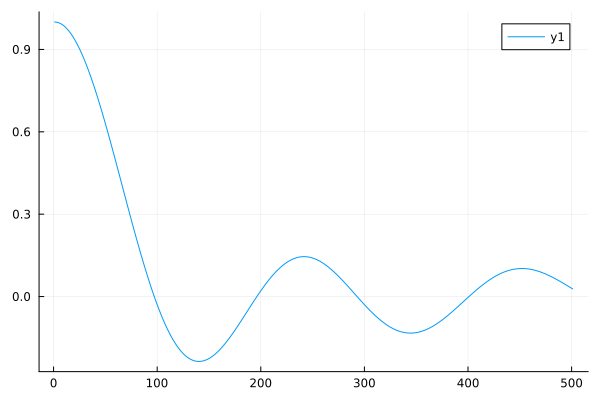

In [17]:
plot(skv)

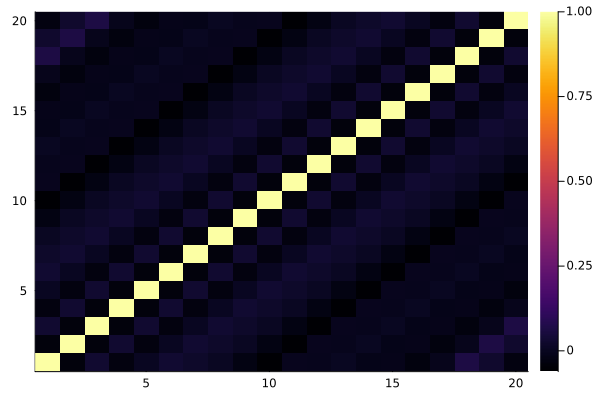

In [18]:
heatmap(similarity_outer(ad[:,:,1:1], ad[:,:,1:1], dims=2)[:,:,1])

In [19]:
struct KeyValueData
    color_marker::AbstractArray{<:Real,2}
    colors::AbstractArray{<:Real,2}
    color_bank::AbstractArray{<:Real,2}
    color_choices::AbstractArray{<:Int,1}

    shape_marker::AbstractArray{<:Real,2}
    shapes::AbstractArray{<:Real,2}
    shape_bank::AbstractArray{<:Real,2}
    shape_choices::AbstractArray{<:Int,1}

    location_marker::AbstractArray{<:Real,2}
    locations::AbstractArray{<:Real,2}
    location_index::AbstractArray{<:Int,1}

    link_marker::AbstractArray{<:Real,2}
    links::AbstractVector{AbstractArray{<:Real,2}}
    link_choices::AbstractVector{AbstractVector{<:Int}}

    symbols::AbstractArray{<:Real,2}
end

In [20]:
function KeyValueData(n_samples::Int; n_colors::Int = 100, n_shapes::Int = 20, n_links::Tuple{<:Int, <:Int} = (1,3), d_vsa::Int = 512, rng::AbstractRNG)
    generate_marker = () -> random_symbols((d_vsa, 1), rng)

    #colors
    color_marker = generate_marker()
    color_choices, color_bank = choose_symbols(n_samples, n_colors, d_vsa, rng)
    colors = color_bank[:,color_choices]

    #shapes
    shape_marker = generate_marker()
    shape_choices, shape_bank = choose_symbols(n_samples, n_shapes, d_vsa, rng)
    shapes = shape_bank[:,shape_choices]

    #locations
    location_marker = generate_marker()
    _, locations = generate_addresses(n_samples, d_vsa, rng)
    locations_indices = collect(1:n_samples)

    #links
    link_marker = generate_marker()
    link_indices = select_edges(n_samples, n_links, rng)
    links = [locations[:,idx] for idx in link_indices]

    #combine data
    symbols = zeros(Float64, (d_vsa, n_samples))
    for i in 1:n_samples
        color_string = v_bind(color_marker, colors[:, i:i])
        shape_string = v_bind(shape_marker, shapes[:, i:i])
        location_string = v_bind(location_marker, locations[:, i:i])

        link_strings = stack([locations[:, l] for l in link_indices[i]], dims=2)
        link_string = v_bind(link_marker, v_bundle(link_strings, dims=2))

        string = v_bundle(stack([color_string, shape_string, location_string, link_string], dims=2), dims=2)
        symbols[:,i:i] = string
    end

    return KeyValueData(color_marker,
                         colors,
                         color_bank,
                         color_choices,
                         shape_marker,
                         shapes,
                         shape_bank,
                         shape_choices,
                         location_marker,
                         locations,
                         locations_indices,
                         link_marker,
                         links,
                         link_indices,
                         symbols)

    # return KeyValueData(color_marker,
    #                      colors,
    #                      color_choices,
    #                      shape_marker,
    #                      shapes,
    #                      shape_choices,
    #                      location_marker,
    #                      locations,
    #                      locations_indices,
    #                      link_marker,
    #                      links,
    #                      link_indices,
    #                      symbols)
    
end

KeyValueData

In [21]:
kv = KeyValueData(32, rng=rng)

KeyValueData([-0.8661201000213623; 0.19297277927398682; … ; -0.35880279541015625; 0.7882692813873291;;], [0.42590582370758057 0.605155348777771 … -0.4683654308319092 0.06126141548156738; -0.6399070024490356 -0.6593366861343384 … 0.03552377223968506 -0.7425521612167358; … ; 0.38557326793670654 0.9808140993118286 … -0.6360534429550171 0.12502527236938477; 0.19276118278503418 -0.11798632144927979 … 0.09099936485290527 0.17120003700256348], [0.22108304500579834 -0.9266397953033447 … 0.6492582559585571 -0.5852980613708496; -0.05466794967651367 0.6392378807067871 … -0.05855977535247803 0.05404102802276611; … ; 0.059370994567871094 -0.861544132232666 … -0.3269519805908203 -0.6070995330810547; -0.377269983291626 0.1941589117050171 … 0.5405981540679932 -0.5506776571273804], [75, 78, 4, 40, 86, 92, 57, 39, 42, 24  …  84, 21, 43, 78, 3, 42, 57, 79, 7, 56], [-0.29223179817199707; -0.21629250049591064; … ; 0.8317346572875977; -0.8419104814529419;;], [0.04459583759307861 0.0830085277557373 … -0.8419

In [22]:
kv.color_marker

512×1 Matrix{Float64}:
 -0.8661201000213623
  0.19297277927398682
  0.1739567518234253
 -0.22611427307128906
 -0.20363712310791016
  0.8024662733078003
 -0.3374354839324951
 -0.4978381395339966
  0.04387235641479492
  0.9656368494033813
 -0.7153493165969849
 -0.32590556144714355
  0.16817843914031982
  ⋮
 -0.1240311861038208
  0.29347705841064453
  0.8144911527633667
  0.16163313388824463
  0.7998852729797363
  0.8840855360031128
  0.4260793924331665
  0.4552873373031616
  0.3120929002761841
  0.9918069839477539
 -0.35880279541015625
  0.7882692813873291

In [23]:
import Base.length, Base.size

function length(kv::KeyValueData)
    return size(kv.locations,2)
end

function size(kv::KeyValueData)
    return kv.locations |> size
end

size (generic function with 441 methods)

In [24]:
length(kv)

32

In [25]:
kv_fields = [:color, :shape, :link, :location]

4-element Vector{Symbol}:
 :color
 :shape
 :link
 :location

In [26]:
function generate_direct_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = v_bind(kvs.location_marker, kvs.locations[:, index:index])

    #generate the query
    if marker == :color
        tag = kvs.color_marker
        value = kvs.colors[:, index:index]
    elseif marker == :shape
        tag = kvs.shape_marker
        value = kvs.shapes[:, index:index]
    elseif marker == :link
        tag = kvs.link_marker
        value = v_bundle(kvs.links[index], dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = kvs.locations[:, index:index]
    end

    query = v_bundle((address, tag), dims=2)
    return query, value
end

generate_direct_query (generic function with 1 method)

In [27]:
dqx, dqy = generate_direct_query(:link, 10, kv)

([0.5197351574897767; 0.23234045505523682; … ; -0.10287302732467651; -0.6423741579055786;;], [-0.6718346450928974; 0.9461848903321581; … ; 0.2391245850540429; 0.6869968130105969;;])

In [28]:
dqx

512×1 Matrix{Float64}:
  0.5197351574897767
  0.23234045505523682
  0.9573487639427185
  0.8035214861113694
  0.5763610323149827
  0.5708304643630981
 -0.8263427932936814
 -0.558736562728882
  0.1984768509864807
 -0.5342928171157838
  0.8229618668556213
  0.09857422113418579
  0.18404138088226332
  ⋮
 -0.05563843250274658
 -0.5029951930046083
  0.9917232115943101
  0.5711571574211121
  0.8493208289146423
  0.7524400353431702
 -0.5428197979927064
 -0.052502214908599854
  0.4995808005332947
 -0.48602789640426636
 -0.10287302732467651
 -0.6423741579055786

In [29]:
dqy

512×1 Matrix{Float64}:
 -0.6718346450928974
  0.9461848903321581
  0.3763591335873001
  0.643848794595568
  0.3602476769431992
 -0.7883972631502302
  0.6916585698502821
  0.2558710889166408
  0.6459588893166115
 -0.6733170449634882
  0.8233855006937586
  0.6168966490230497
  0.5554620112437862
  ⋮
  0.9529519229849563
  0.017463474949726006
  0.5291478365539397
 -0.16345401062398351
 -0.6141439036005077
  0.37286753136869566
 -0.6690765813447818
  0.20083256541282363
 -0.05066032869309519
 -0.8343874629243818
  0.2391245850540429
  0.6869968130105969

In [30]:
function generate_indirect_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = kvs.locations[:, index:index]
    link = kvs.link_marker
    link_indices = kvs.link_choices[index]

    #bundle together the result of the query from the child nodes
    function bundle_values(register, indices)
        values = register[:, indices]
        value = v_bundle(values, dims=2)
        return value
    end

    if marker == :color
        tag = kvs.color_marker
        value = bundle_values(kvs.colors, link_indices)
    elseif marker == :shape
        tag = kvs.shape_marker
        value = bundle_values(kvs.shapes, link_indices)
    elseif marker == :link
        tag = kvs.link_marker
        values = cat((kvs.links[link_indices]...), dims=2)
        #return values
        value = v_bundle(values, dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = bundle_values(kvs.locations, link_indices)
    end

    reference = v_bundle((v_bind((kvs.location_marker, address), dims=2), kvs.link_marker), dims=2)
    query = v_bundle((v_bind((kvs.location_marker, reference), dims=2), tag), dims=2)
    return query, value
end

generate_indirect_query (generic function with 1 method)

In [31]:
iqx, iqy = generate_indirect_query(:link, 10, kv)

([-0.07767620682716364; -0.4698137640953064; … ; -0.04046264290809634; 0.9726848920066026;;], [-0.4764642763609094; -0.9596567518468291; … ; 0.9168999888738294; 0.43277054475624055;;])

In [32]:
iqx

512×1 Matrix{Float64}:
 -0.07767620682716364
 -0.4698137640953064
  0.7482347786426544
 -0.4023055573364663
  0.8250285565672616
  0.6014674305915833
 -0.7961326420126656
 -0.1427828073501587
  0.22336789965629575
 -0.6579188704490662
  0.5985892713069917
 -0.12627974152565008
 -0.2913187146186828
  ⋮
  0.09499269723892208
 -0.06733253598213199
  0.9582245230494241
  0.03029814362525939
  0.8672290146350861
  0.8693788945674896
 -0.673013061285019
  0.043980628252029426
  0.6554615795612335
 -0.6738732159137726
 -0.04046264290809634
  0.9726848920066026

In [33]:
iqy

512×1 Matrix{Float64}:
 -0.4764642763609094
 -0.9596567518468291
  0.24192850217473688
 -0.028730671217183458
  0.468828351352418
  0.9398731318808065
  0.4384459527222274
  0.5757114121157048
  0.43846145782301393
 -0.4769196625785056
 -0.0074700993029549224
 -0.06198581871101353
  0.43175969155272254
  ⋮
 -0.9604874043860283
  0.237809348161525
  0.7091664073225152
  0.1473772362523389
  0.9015214695732654
 -0.9200347202166743
 -0.4756077668881528
  0.9120979451828727
 -0.3881197578282809
  0.9981505240353488
  0.9168999888738294
  0.43277054475624055

In [34]:
function permute_shuffle(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    n_permutations = length(kv_fields) * length(kvs)
    @assert n_samples < n_permutations "Must have n_samples < n_permutations for unique samples"

    #select which queries to make at random
    permutations = [(field, i) for field in kv_fields, i in 1:length(kvs)]
    permutations = shuffle!(rng, permutations)[1:n_samples]
    return permutations
end

permute_shuffle (generic function with 1 method)

In [35]:
function direct_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_direct_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

direct_dataset (generic function with 1 method)

In [36]:
ddx, ddy = direct_dataset(100, kv, rng)

([0.1350426077842712 -0.4089899659156799 … -0.8948131203651428 -0.637587698288646; -0.3315642476081848 -0.19960182905197144 … -0.05426138639450074 0.9259910901267198; … ; -0.7085770090300706 -0.7493844946105149 … -0.858306976147379 0.47141844034194946; -0.4990971088409424 0.5414943099021912 … -0.9095087369162705 -0.01165604591369623], [0.8276315927505493 -0.9062849283218384 … -0.5711255073547363 0.8005715608596802; -0.8612439632415771 -0.7055126428604126 … 0.37463152408599854 0.2369626760482788; … ; -0.41813111305236816 0.9703257083892822 … 0.47690749168395996 0.3218430280685425; -0.21200931072235107 0.2454131841659546 … 0.5128493309020996 0.8677661418914795])

In [37]:
ddx |> size

(512, 100)

In [38]:
ddy |> size

(512, 100)

In [39]:
function indirect_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_indirect_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

indirect_dataset (generic function with 1 method)

In [40]:
idx, idy = indirect_dataset(100, kv, rng)

([-0.9492176194865373 -0.7920815944671631 … -0.3194095631500648 0.9221369624137878; 0.543741285800934 0.30282506346702576 … 0.08002486824989323 0.9829206486422685; … ; -0.021128207445144657 -0.21543586254119873 … -0.7315517981726792 0.3395211696624756; 0.575679526720388 0.9224918206412461 … 0.9137773235518601 -0.049784674253122704], [-0.9821418822623063 -0.7033932909191395 … 0.49197225513631626 0.9019389396497467; -0.6584934466374469 -0.2601362151690044 … -0.38863639830336366 0.9935266714454116; … ; -0.7239163817598036 0.26346289204575785 … 0.08861879689282687 0.585129916415499; -0.0769610843229777 0.2027229614940661 … -0.5415288632220255 -0.9560572586456185])

In [41]:
idx |> size

(512, 100)

In [42]:
idy |> size

(512, 100)

# Setup an xformer network

In [43]:
a = random_symbols((512, 10), rng)
b = random_symbols((512, 64, 10), rng);

In [44]:
struct SingleHeadAttention <: LuxCore.AbstractLuxContainerLayer{(:q_proj, :k_proj, :v_proj, :out_proj)}
    q_proj
    k_proj
    v_proj
    out_proj
end

In [45]:
function SingleHeadAttention(d_input::Int, d_model::Int; init=variance_scaling)
    SingleHeadAttention(
        PhasorDense(d_input => d_model; init),  # Query
        PhasorDense(d_input => d_model; init),  # Key
        PhasorDense(d_input => d_model; init),  # Value
        PhasorDense(d_model => d_input; init)   # Output
    )
end

SingleHeadAttention

In [46]:
function (m::SingleHeadAttention)(q, kv, ps, st)
    q = m.q_proj(q, ps.q_proj, st.q_proj)[1]
    k = m.k_proj(kv, ps.k_proj, st.k_proj)[1]
    v = m.v_proj(kv, ps.v_proj, st.v_proj)[1]
    
    # Single-head attention (nheads=1)
    attn_out = attend(q, k, v)
    output = m.out_proj(attn_out, ps.out_proj, st.out_proj)[1]
    
    return output, ()
end

In [47]:
identity_layer = Chain(x -> x,)

Chain(
    layer_1 = WrappedFunction(#30),
)         # Total: 0 parameters,
          #        plus 0 states.

In [48]:
n1 = Chain(PhasorDense(n_hd => n_hd),)

Chain(
    layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
)         # Total: 263_168 parameters,
          #        plus 0 states.

In [49]:
typeof((1,3,4)) <: Tuple{Vararg{<:Int}}

true

In [50]:
p1 = Lux.setup(rng, n1, )

((layer_1 = (weight = Float32[0.03707627 0.017316332 … 0.044608746 0.054087777; -0.08457034 0.03461641 … 0.055903554 0.0901459; … ; -0.053898368 0.06893188 … 0.015486689 0.012295164; 0.008499372 -0.037114874 … -0.015760778 0.003131628], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), (layer_1 = NamedTuple(),))

In [52]:
kvs = kv.symbols;

In [55]:
kv2 = n1(kvs, p1[1], p1[2])[1]

512×32 Matrix{Float64}:
 -0.0102889   0.116027    -0.489729    …  -0.102585    -0.221059    0.338062
 -0.269789    0.0296427    0.00575425     -0.0739503    0.143135    0.275972
 -0.16983    -0.0620608    0.536773       -0.27783      0.0525285  -0.259613
 -0.107566    0.00479041  -0.0462424       0.212339    -0.355054    0.261513
 -0.0665837   0.109953     0.0468708       0.148843     0.0451534  -0.0885496
  0.445371   -0.429094    -0.153013    …  -0.110544    -0.174603   -0.193392
 -0.133041   -0.204404     0.514536        0.0524978    0.0684684  -0.0201624
 -0.254866    0.370177    -0.216459        0.633355    -0.0435561   0.225919
  0.199792   -0.348976     0.152456       -0.145545     0.318415    0.0201246
  0.418113   -0.225448    -0.0728675      -0.202362    -0.0101255   0.172248
  0.243756   -0.0152767   -0.11744     …  -0.245789     0.0245212  -0.0676416
  0.253452   -0.175739     0.104146       -0.0961308   -0.585166    0.138998
 -0.155312    0.355002     0.0685854      -0.409

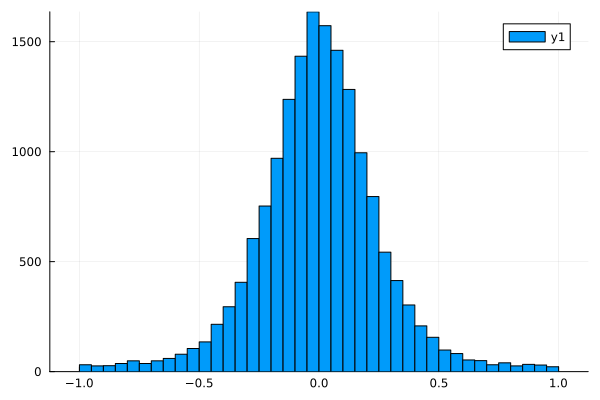

In [56]:
histogram(vec(kv2))

In [57]:
sha = SingleHeadAttention(identity_layer, 
                    identity_layer,
                    Chain(PhasorDense(n_hd => n_hd),),
                    Chain(PhasorDense(n_hd => n_hd),))

SingleHeadAttention(
    q_proj = Chain(
        layer_1 = WrappedFunction(#30),
    ),
    k_proj = Chain(
        layer_1 = WrappedFunction(#30),
    ),
    v_proj = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
    out_proj = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
)         # Total: 526_336 parameters,
          #        plus 0 states.

In [58]:
ddx = ddx[:,:,1:1]
kvs = kv.symbols[:,:,1:1];

In [59]:
size(ddx)

(512, 100, 1)

In [60]:
size(kvs)

(512, 32, 1)

In [61]:
qkvs = similarity_outer(ddx, kvs);

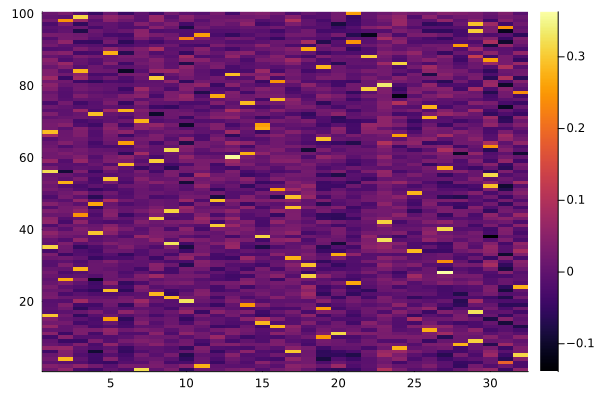

In [62]:
heatmap(qkvs[:,:,1])

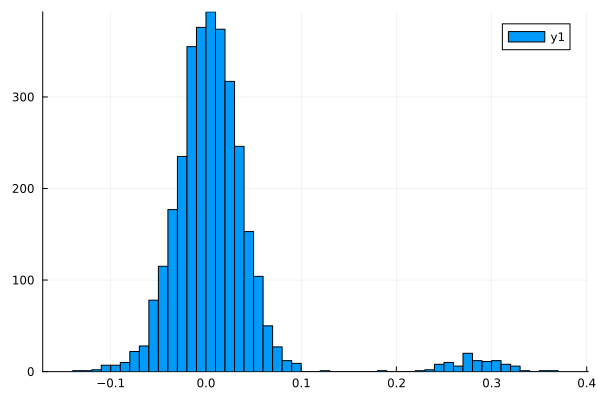

In [63]:
histogram(qkvs|>vec)

In [64]:
ps, st = Lux.setup(rng, sha)

((q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = (weight = Float32[0.046484627 0.036949813 … -0.078979455 -0.015783677; 0.04599454 0.009483468 … -0.04780482 0.07962409; … ; 0.07785712 -0.029458668 … 0.00051840633 -0.09471306; -0.043653153 -0.00017168609 … 0.0052362382 0.0050259233], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), out_proj = (layer_1 = (weight = Float32[0.052639276 0.025836147 … -0.013223348 0.08453947; -0.027983932 0.0196588 … -0.060268354 0.08855769; … ; 0.0046526897 -0.05545093 … 0.037256327 -0.044009697; 0.054091226 0.033379134 … -0.04993289 0.000253996], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0

In [67]:
y0 = sha(ddx, kvs, ps, st)

([-0.3630518423440759 -0.1580027168934328 … -0.0828763563048524 0.1081297989017216; 0.2980757880503541 -0.08640957056245491 … 0.0645683321767582 0.22030995173265386; … ; 0.048524565246811056 -0.015458938907281852 … 0.06664146040667537 -0.054348506563578765; -0.1094705092925656 -0.1274751699587315 … 0.09018769828360754 0.47646777331139895;;;], ())

In [68]:
y0[1] |> size

(512, 100, 1)

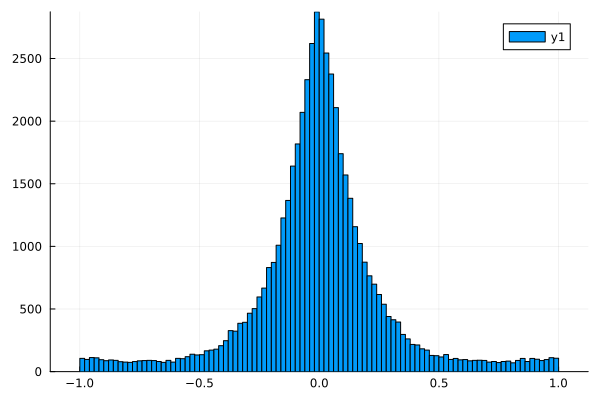

In [69]:
histogram(y0[1]|>vec)

In [112]:
struct SingleHeadTransformerBlock <: LuxCore.AbstractLuxContainerLayer{(:attn, :norm1, :norm2, :ff)}
    attn::SingleHeadAttention
    norm1
    norm2
    ff
end

In [ ]:
function SingleHeadTransformerBlock(d_input::Int, d_model::Int, d_ff::Int; dropout=0.1)
    SingleHeadTransformerBlock(
        SingleHeadAttention(d_input, d_model),
        LayerNorm((d_model,)),
        LayerNorm((d_model,)),
        Chain(
            Dense(d_model, d_ff, relu),
            Dropout(dropout),
            Dense(d_ff, d_model)
        )
    )
end

In [ ]:
function (tb::SingleHeadTransformerBlock)(x, mask, ps, st)
    # Attention path
    norm_x = tb.norm1(x, ps.norm1, st.norm1)[1]
    attn_out, st_attn = tb.attn(norm_x, mask, ps.attn, st.attn)
    x = x .+ attn_out
    
    # Feed-forward path
    norm_x = tb.norm2(x, ps.norm2, st.norm2)[1]
    ff_out, st_ff = tb.ff(norm_x, ps.ff, st.ff)
    x = x .+ ff_out
    
    return x, merge(st_attn, st_ff)
end

In [ ]:
# Usage example
d_model = 512
d_ff = 2048
rng = Random.default_rng()

model = SingleHeadTransformerBlock(d_model, d_ff)
ps, st = Lux.setup(rng, model)

# Input: (sequence_length × features × batch_size)
x = randn(Float32, 32, d_model, 1)
output, st = model(x, nothing, ps, st)